In [1]:
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, det_curve
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from torch import Tensor
from collections import defaultdict
import numpy as np
import time
from representation_model import PENetwork, CompositeClassifierFromRepresentations
ROOT = "../../"
import sys
sys.path.append(ROOT)
from utils.functions import sigmoid, fix_random_seed
from models import Filepath, Emulation

SEED = 42
fix_random_seed(SEED)

dataset_folder = "/data/quo.vadis/evaluation/representations/set_cropped_20/"
dataset_folder = "/data/quo.vadis/evaluation/representations/set_full/"

X_train = np.load(open(dataset_folder + "Xtrain.npy", "rb"))
y_train = np.load(open(dataset_folder + "ytrain.npy", "rb"))
X_val = np.load(open(dataset_folder + "Xval.npy", "rb"))
y_val = np.load(open(dataset_folder + "yval.npy", "rb"))

In [20]:
def fit(models, x_trains, y_train, save=False):
    for model in models:
        print(f"Fitting model: {model}", end=" | ")
        c1 = time.time()
        models[model].fit(x_trains[model], y_train)
        if save:
            models[model].save_meta_model()
        print(f"Took: {time.time() - c1:.2f}s")

def evaluate(models_dict, Xs, y, ax=None, threshold=0.6, print_score=True):
    probs = {}
    for model in models_dict:
        print(f"[!] Evaluating model: {model}...")

        probs[model] = models_dict[model].predict_proba(Xs[model])[:,1]        
        preds = np.where(probs[model] > threshold, 1, 0)
        
        if print_score:
            print("\n", "="*6, f"{model}", "="*6)
            print(f"ROC AUC score: {roc_auc_score(y, probs[model])}")
            print(f"Classification report:")
            print(classification_report(y, preds, digits=4))

    model = "No Skill"
    most_common_label = np.argmax(np.bincount(y.astype(int)))
    probs[model] = np.array([most_common_label for _ in range(len(y))], dtype=int)
    
    if not ax:
        _, ax = plt.subplots(figsize=(14,6))
    
    for model in probs:
        fpr, tpr, _ = roc_curve(y, probs[model])
        # plot the roc curve for the model
        linestyle = "--" if model == "No Skill" else "solid"
        ax.plot(fpr, tpr, linestyle=linestyle, label=model)
        # axis labels
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    _ = ax.legend()
    return probs

## Building Xs and modules for analysis of different module combinations

In [3]:
X_trains = {}
X_vals = {}
models = {}

modulelist = [["ember"], ["filepaths"], ["emulation"], 
            ["filepaths", "emulation"], ["ember", "emulation"], 
            ["ember", "filepaths"], ["ember", "filepaths", "emulation"]]

mm = CompositeClassifierFromRepresentations(root=ROOT)

for combination in modulelist:
    name = " & ".join(combination)
    models[name] = CompositeClassifierFromRepresentations(root=ROOT, 
                                                meta_model = "MultiLayerPerceptron",
                                                load_meta_model = False,
                                                mlp_hidden_layer_sizes=(64, 16),
                                                meta_fit_max_iter=400)
    
    X_trains[name] = mm.get_modular_x(combination, X_train)
    X_vals[name] = mm.get_modular_x(combination, X_val)

In [4]:
fit(models, X_trains, y_train)

Fitting model: ember | Took: 30.89s
Fitting model: filepaths | Took: 7.08s
Fitting model: emulation | Took: 11.56s
Fitting model: filepaths & emulation | Took: 11.26s
Fitting model: ember & emulation | Took: 21.19s
Fitting model: ember & filepaths | Took: 6.35s
Fitting model: ember & filepaths & emulation | Took: 5.27s


[!] Evaluating model: ember...

 ====== ember ======
ROC AUC score: 0.9904187391683231
Classification report:
              precision    recall  f1-score   support

         0.0     0.9531    0.9468    0.9500      4982
         1.0     0.9799    0.9823    0.9811     13120

    accuracy                         0.9725     18102
   macro avg     0.9665    0.9646    0.9655     18102
weighted avg     0.9725    0.9725    0.9725     18102

[!] Evaluating model: filepaths...

 ====== filepaths ======
ROC AUC score: 0.9880588563952178
Classification report:
              precision    recall  f1-score   support

         0.0     0.9457    0.9432    0.9444      4982
         1.0     0.9785    0.9794    0.9789     13120

    accuracy                         0.9695     18102
   macro avg     0.9621    0.9613    0.9617     18102
weighted avg     0.9694    0.9695    0.9694     18102

[!] Evaluating model: emulation...

 ====== emulation ======
ROC AUC score: 0.9870968183631806
Classification report:


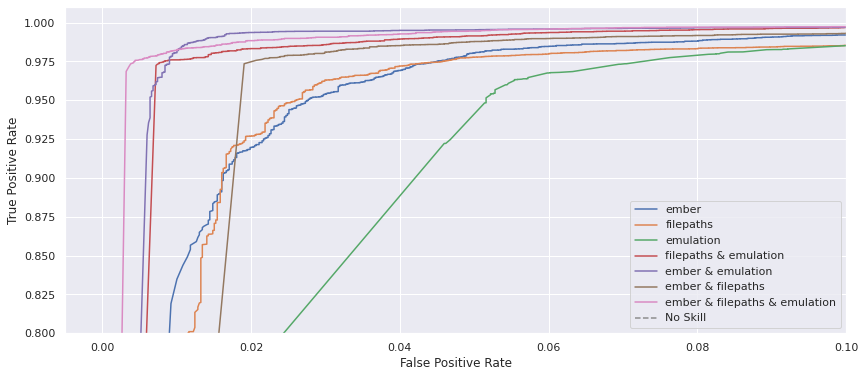

In [5]:
pp = evaluate(models, X_vals, y_val)
plt.xlim([-0.005, 0.1])
plt.ylim([0.8, 1.01])
plt.legend(loc="lower right")

# Detection rates under fixed false positive rate (FPR)

In [8]:
def get_threshold_from_rate(thresholds, rate_array, rate):
    index = np.where(rate_array >= rate)[0][0]
    return thresholds[index]

def get_value_from_threshold(values, thresholds, threshold):
    try:
        thr_index = np.where(thresholds <= threshold)[0][0]
    except IndexError:
        thr_index = 0
    return values[thr_index]

def get_dicts_for_magic_analysis(models, Xs, y):
    probs = {}
    for model in models:
        probs[model] = models[model].predict_proba(Xs[model])[:,1]

    fprs, fnrs, tprs, thresholds_roc, thresholds_det = {},{},{},{},{}

    for model in probs:
        fprs[model], tprs[model], thresholds_roc[model] = roc_curve(y, probs[model])
        _, fnrs[model], thresholds_det[model] = det_curve(y, probs[model])
    
    return fprs, fnrs, tprs, thresholds_roc, thresholds_det 

def do_magic_analysis(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fpr_rates=list(np.arange(0.0000025, 0.000031, 0.0000025))):
    fixed_fpr_rates = defaultdict(list)
    for fpr_rate in fpr_rates: # TBD
        print("===" * 10)
        for model in models:
            threshold = get_threshold_from_rate(thresholds_roc[model], fprs[model], fpr_rate)
            tpr_rate = get_value_from_threshold(tprs[model], thresholds_roc[model], threshold)
            fnr_rate = get_value_from_threshold(fnrs[model], thresholds_det[model][::-1], threshold)
            fnr_rate = 0
            fixed_fpr_rates[model].append([fpr_rate, tpr_rate, fnr_rate, threshold]) 
            print(f"FPR: {fpr_rate*100:>5.3f}% | TPR: {tpr_rate*100:>5.2f}% | FNR: {fnr_rate*100:>5.2f}% | Thr.: {threshold:>5.4f} | {model}")

    # keys for y label
    keys = models.keys()

    # rates for x label
    fpr_rates = [np.array(fixed_fpr_rates[key])[:,0] for key in fixed_fpr_rates][0]
    fpr_rates = [np.round(x*10000, 2) for x in fpr_rates] # TBD

    # rearrange rows, so "all" is last
    tpr_rates = np.vstack([np.array(fixed_fpr_rates[key])[:,1] for key in fixed_fpr_rates])
    tpr_rates = np.round(tpr_rates*100,2)

    fig, ax = plt.subplots(figsize=(13,7))
    ax = sns.heatmap(tpr_rates, ax = ax,
                annot=True, fmt=".2f",
                xticklabels=[x for x in fpr_rates],
                yticklabels=[x.replace(" & ", " &\n") for x in keys])

    ax.set_xlabel(r"False Positive rate, $\frac{1}{1e^{-4}}$", fontsize=12)
    ax.set_ylabel("Modules", fontsize=12)
    _ = ax.set_title("Detection rate (%) with fixed False Positive rate", fontsize=14)

    #fig.savefig("/data/quo.vadis/img/rate_heatmap.eps",  format='eps', dpi=600, bbox_inches='tight')

FPR: 0.000% | TPR: 81.91% | FNR:  0.00% | Thr.: 1.0000 | ember
FPR: 0.000% | TPR: 34.46% | FNR:  0.00% | Thr.: 1.0000 | filepaths
FPR: 0.000% | TPR: 13.52% | FNR:  0.00% | Thr.: 1.0000 | emulation
FPR: 0.000% | TPR: 97.25% | FNR:  0.00% | Thr.: 1.0000 | filepaths & emulation
FPR: 0.000% | TPR: 92.77% | FNR:  0.00% | Thr.: 1.0000 | ember & emulation
FPR: 0.000% | TPR: 97.36% | FNR:  0.00% | Thr.: 1.0000 | ember & filepaths
FPR: 0.000% | TPR: 96.86% | FNR:  0.00% | Thr.: 1.0000 | ember & filepaths & emulation
FPR: 0.025% | TPR: 81.91% | FNR:  0.00% | Thr.: 1.0000 | ember
FPR: 0.025% | TPR: 34.46% | FNR:  0.00% | Thr.: 1.0000 | filepaths
FPR: 0.025% | TPR: 27.14% | FNR:  0.00% | Thr.: 0.9999 | emulation
FPR: 0.025% | TPR: 97.25% | FNR:  0.00% | Thr.: 1.0000 | filepaths & emulation
FPR: 0.025% | TPR: 92.77% | FNR:  0.00% | Thr.: 1.0000 | ember & emulation
FPR: 0.025% | TPR: 97.36% | FNR:  0.00% | Thr.: 1.0000 | ember & filepaths
FPR: 0.025% | TPR: 96.86% | FNR:  0.00% | Thr.: 1.0000 | embe

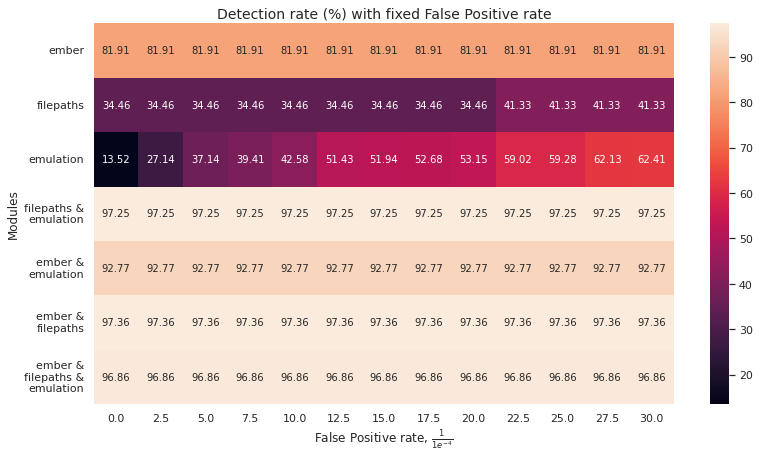

In [9]:
fprs, fnrs, tprs, thresholds_roc, thresholds_det = get_dicts_for_magic_analysis(models, X_vals, y_val)
do_magic_analysis(models, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fpr_rates=list(np.arange(2.5e-8, 3.01e-3, 2.5e-4)))

# Different meta-models

In [15]:
models_meta = {}

modules = ["ember", "filepaths", "emulation"]
models_meta["Logistic Regression"] = CompositeClassifierFromRepresentations(modules=modules, 
                                                                        meta_model="LogisticRegression", 
                                                                        load_meta_model = False,
                                                                        root=ROOT)
models_meta["XGBClassifier"] = CompositeClassifierFromRepresentations(modules=modules, 
                                                                    meta_model="XGBClassifier",
                                                                    load_meta_model = False,
                                                                    root=ROOT)
models_meta["MultiLayerPerceptronShallow"] = CompositeClassifierFromRepresentations(modules=modules, 
                                                                    meta_model="MultiLayerPerceptron",
                                                                    load_meta_model = False,
                                                                    root=ROOT, 
                                                                    mlp_hidden_layer_sizes=(32,),
                                                                    meta_fit_max_iter=400)
models_meta["MultiLayerPerceptronMedium"] = CompositeClassifierFromRepresentations(modules=modules, 
                                                                    meta_model="MultiLayerPerceptron",
                                                                    load_meta_model = False,
                                                                    root=ROOT, 
                                                                    mlp_hidden_layer_sizes=(64,16),
                                                                    meta_fit_max_iter=400)
models_meta["MultiLayerPerceptronDeep"] = CompositeClassifierFromRepresentations(modules=modules, 
                                                                    meta_model="MultiLayerPerceptron",
                                                                    load_meta_model = False,
                                                                    root=ROOT, 
                                                                    mlp_hidden_layer_sizes=(128,64,32),
                                                                    meta_fit_max_iter=400)

x_trains = {}
x_vals = {}
for x in models_meta:
    x_trains[x] = X_train
    x_vals[x] = X_val

In [16]:
fit(models_meta, x_trains, y_train)

Fitting model: Logistic Regression | Took: 1.09s
Fitting model: XGBClassifier | Took: 14.43s
Fitting model: MultiLayerPerceptronShallow | Took: 3.86s
Fitting model: MultiLayerPerceptronMedium | Took: 5.36s
Fitting model: MultiLayerPerceptronDeep | Took: 9.63s


[!] Evaluating model: Logistic Regression...

 ====== Logistic Regression ======
ROC AUC score: 0.9987459427108322
Classification report:
              precision    recall  f1-score   support

         0.0     0.9677    0.9791    0.9734      4982
         1.0     0.9920    0.9876    0.9898     13120

    accuracy                         0.9853     18102
   macro avg     0.9799    0.9834    0.9816     18102
weighted avg     0.9853    0.9853    0.9853     18102

[!] Evaluating model: XGBClassifier...

 ====== XGBClassifier ======
ROC AUC score: 0.9985555928170682
Classification report:
              precision    recall  f1-score   support

         0.0     0.9648    0.9637    0.9642      4982
         1.0     0.9862    0.9867    0.9864     13120

    accuracy                         0.9803     18102
   macro avg     0.9755    0.9752    0.9753     18102
weighted avg     0.9803    0.9803    0.9803     18102

[!] Evaluating model: MultiLayerPerceptronShallow...

 ====== MultiLayerPerceptron

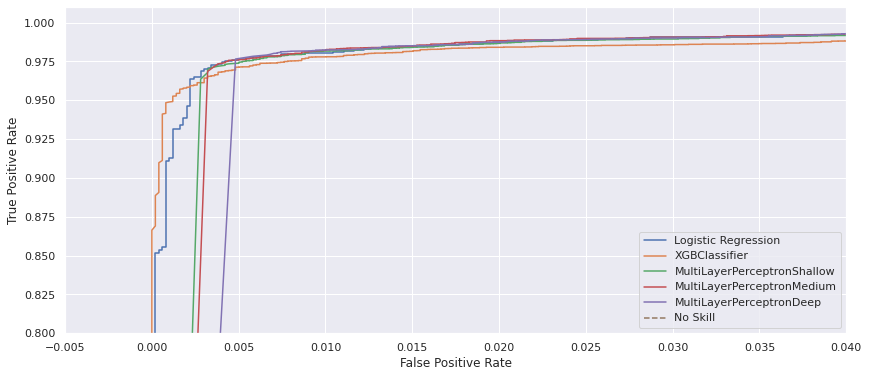

In [25]:
pp = evaluate(models_meta, x_vals, y_val)
plt.xlim([-0.005, 0.04])
plt.ylim([0.8, 1.01])
plt.legend(loc="lower right")

FPR: 0.000% | TPR: 72.55% | FNR:  0.00% | Thr.: 1.0000 | Logistic Regression
FPR: 0.000% | TPR: 86.91% | FNR:  0.00% | Thr.: 1.0000 | XGBClassifier
FPR: 0.000% | TPR: 96.36% | FNR:  0.00% | Thr.: 1.0000 | MultiLayerPerceptronShallow
FPR: 0.000% | TPR: 96.86% | FNR:  0.00% | Thr.: 1.0000 | MultiLayerPerceptronMedium
FPR: 0.000% | TPR: 97.66% | FNR:  0.00% | Thr.: 1.0000 | MultiLayerPerceptronDeep
FPR: 0.025% | TPR: 85.19% | FNR:  0.00% | Thr.: 1.0000 | Logistic Regression
FPR: 0.025% | TPR: 89.07% | FNR:  0.00% | Thr.: 1.0000 | XGBClassifier
FPR: 0.025% | TPR: 96.36% | FNR:  0.00% | Thr.: 1.0000 | MultiLayerPerceptronShallow
FPR: 0.025% | TPR: 96.86% | FNR:  0.00% | Thr.: 1.0000 | MultiLayerPerceptronMedium
FPR: 0.025% | TPR: 97.66% | FNR:  0.00% | Thr.: 1.0000 | MultiLayerPerceptronDeep
FPR: 0.050% | TPR: 85.35% | FNR:  0.00% | Thr.: 1.0000 | Logistic Regression
FPR: 0.050% | TPR: 91.13% | FNR:  0.00% | Thr.: 1.0000 | XGBClassifier
FPR: 0.050% | TPR: 96.36% | FNR:  0.00% | Thr.: 1.0000

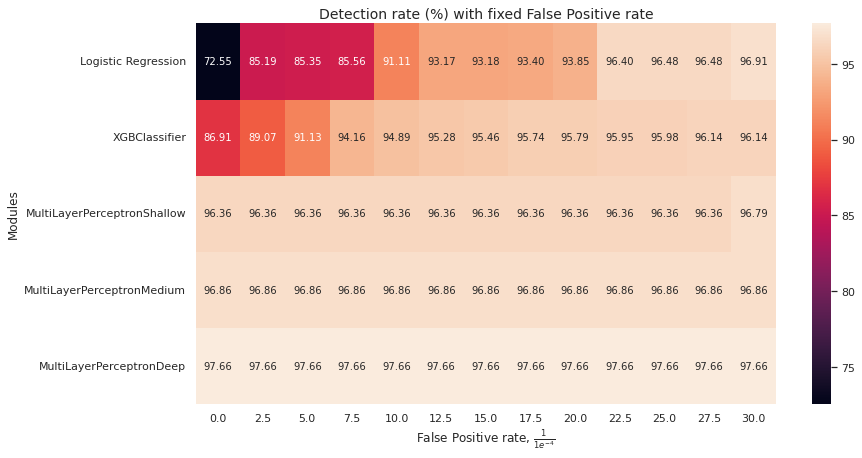

In [26]:
fprs, fnrs, tprs, thresholds_roc, thresholds_det = get_dicts_for_magic_analysis(models_meta, x_vals, y_val)
do_magic_analysis(models_meta, fprs, fnrs, tprs, thresholds_roc, thresholds_det, fpr_rates=list(np.arange(2.5e-8, 3.01e-3, 2.5e-4)))